# Time and Pseudotime for trajectories

Prerequisites:
- You have preprocessed your adata using dimentionaly reduction tools (PCA and PHATE) into the data/preprocessed directory. [notebook: 2-dim-reduction-latent-spaces]: 
    - gene values on _X_ (adata.X)
    - phate embeddings of the data on _obsm_ (ex.: adata.obsm['X_phate])
    - any extra metadata on _obs_ (ex.: adata.obs['time'], adata.obs['disease_progression'], etc...)


In this notebook, we will:
- Use the latent spaces to determine a time features
- In our case, since we have actual time labels, we just need to smooth it using some denoising method.
- In other cases we can use different features to determine pseudotime.
- In the end, we need the same adata object but with a new feature that determine each data point time

In [1]:
import phate
import scprep
import pandas as pd
import scanpy as sc

import os

PROCESSED_DATA_DIR = os.path.join('../../data', 'processed')

print(PROCESSED_DATA_DIR)

../../data/processed


In [4]:
adata = sc.read(os.path.join(PROCESSED_DATA_DIR, 'adata_phate.h5ad'))
adata

AnnData object with n_obs × n_vars = 17944 × 18019
    obs: 'time_label'
    uns: 'pca'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'

## 1. Retrieve the time feature
In our case the time feature is known and was stored under `adata.obs['time_label']`.

If your data had another feature, like cell_cycle_phase under `adata.obs['cell_cycle']` you can use that as a way to calculate a pseudotime

First, let's verify our current PHATE plot

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='PHATE1', ylabel='PHATE2'>

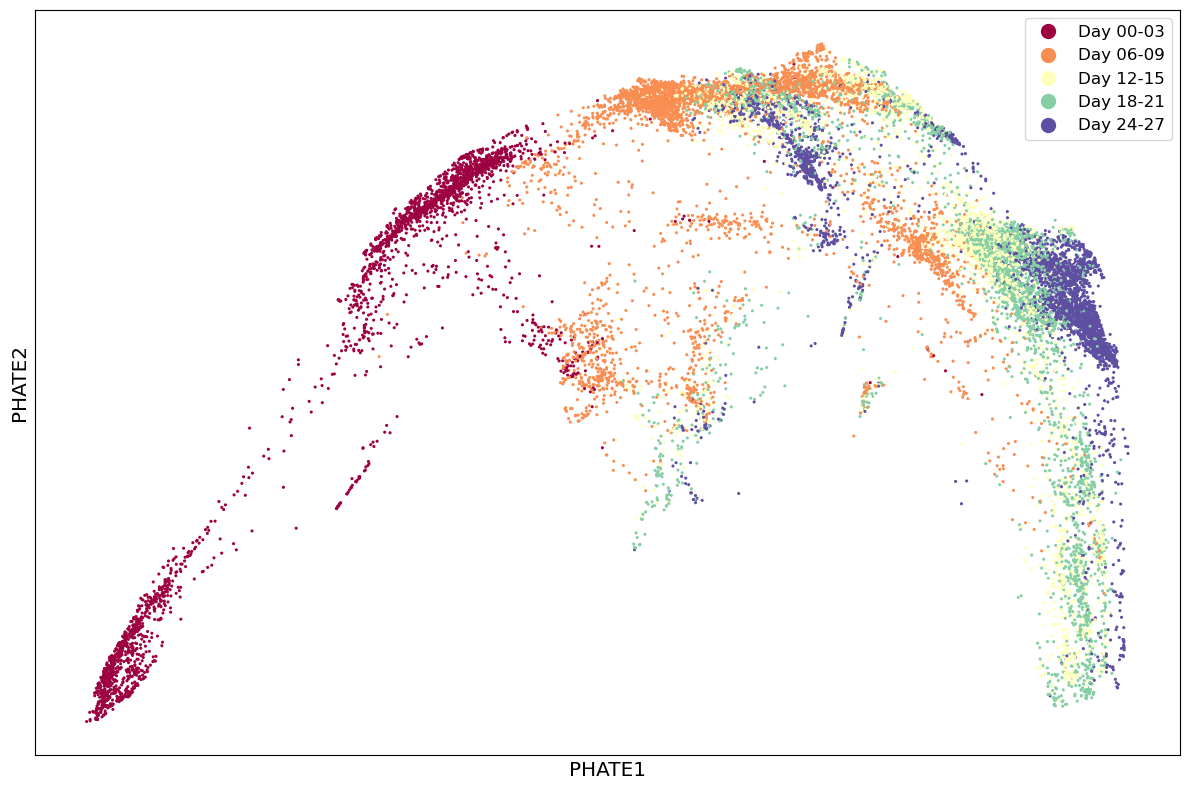

In [14]:
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['time_label'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

### Runing MELD to smooth the time signal

As we can see, the PHATE plot has some regions where the transition between days is not smooth. We need to denoise this regions.
A solution to this is [MELD](https://github.com/KrishnaswamyLab/MELD) a tool to denoise our data via a binarization mechanism.

Since we know the final points and the initial one on our data, we can binarize our time in order to force a proper state flow.

In [8]:
binary_time = adata.obs['time_label'].isin(['Day 00-03', 'Day 06-09', 'Day 12-15'])

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='PHATE1', ylabel='PHATE2'>

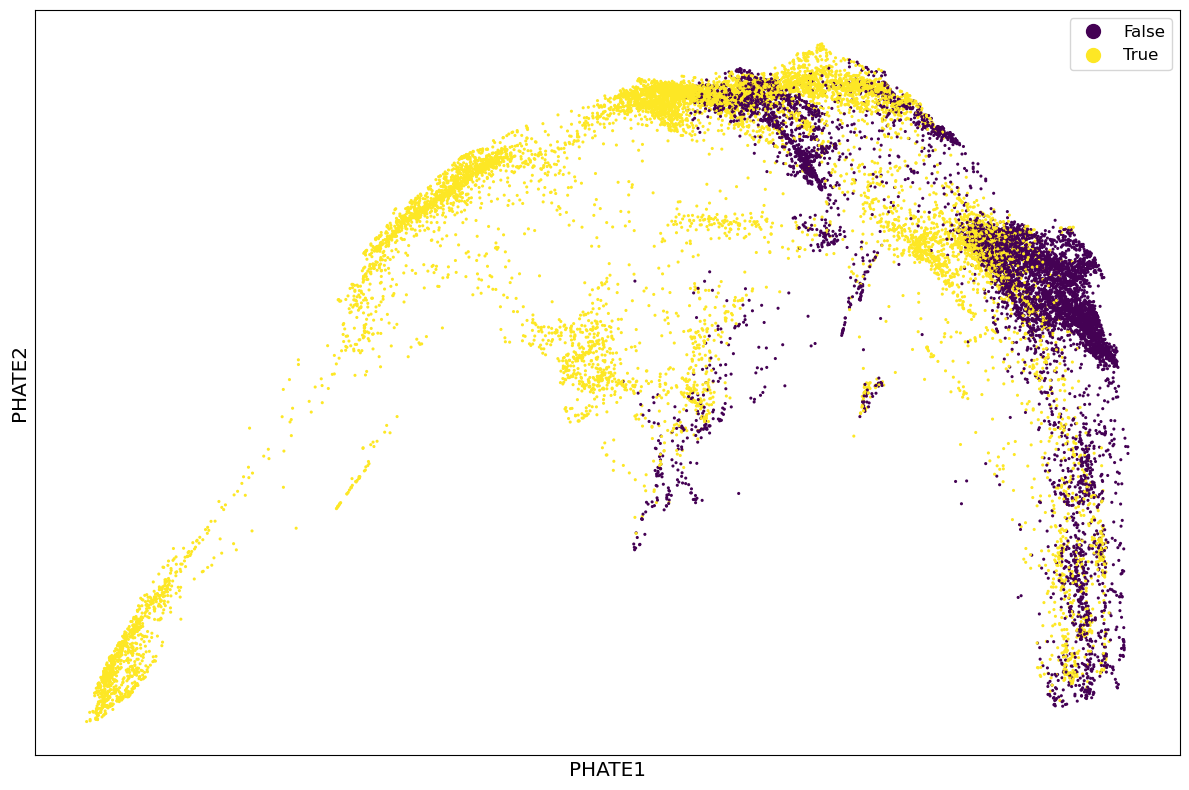

In [13]:
scprep.plot.scatter2d(adata.obsm['X_phate'], c=binary_time, figsize=(12,8), cmap="viridis",
                      ticks=False, label_prefix="PHATE")

In [23]:
meld_op = meld.MELD()
sample_densities = meld_op.fit_transform(X_phate, sample_labels=binary_time)
chd_likelihood = meld.normalize_densities(sample_densities)

Building graph on 19400 samples and 3 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.49 seconds.
  Calculating affinities...
  Calculated affinities in 0.06 seconds.
Calculated graph and diffusion operator in 0.77 seconds.


<Axes: >

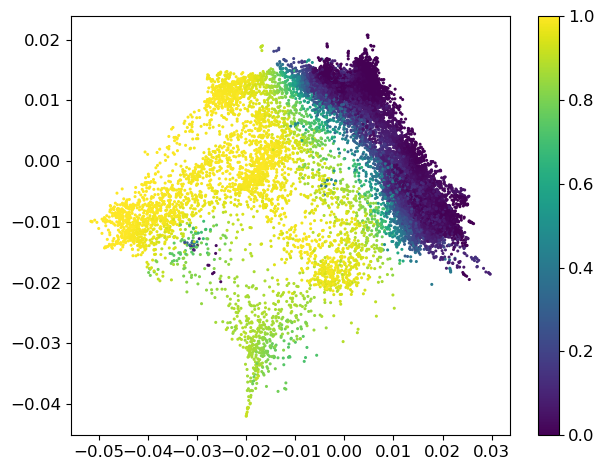

In [24]:
scprep.plot.scatter2d(X_phate, c=chd_likelihood[False], cmap='viridis')

#### Saving the new MELD objects

In [ ]:
PROCESSED_DATA_DIR = os.path.join('../../data', 'processed')

adata.obs['meld_likelihood'] = chd_likelihood[False].to_numpy()

adata.write(os.path.join(PROCESSED_DATA_DIR, 'adata_meld.h5ad'))